In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# 1. Load and prepare the dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# For visualization later, it's often helpful to work with 2 features.
# Let's pick the first two features for simplicity in 2D plotting.
# For actual model training, you'd typically use all features or selected important ones.
X_2d = X[:, :2] # Using only the first two features for 2D visualization

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.3, random_state=42, stratify=y)


# It's good practice to scale features for SVMs, especially with RBF kernel
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the 2D data as well for consistency in plotting later
scaler_2d = StandardScaler()
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d)

print("Dataset loaded and prepared:")
print(f"Features shape (full): {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features shape (2D for visualization): {X_2d.shape}")

Dataset loaded and prepared:
Features shape (full): (569, 30)
Target shape: (569,)
Features shape (2D for visualization): (569, 2)


In [2]:
# 2. Train an SVM with linear and RBF kernel

# Linear Kernel SVM
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# RBF Kernel SVM
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

print("\nSVM Models Training Complete:")
print(f"Linear Kernel SVM Training Accuracy: {svm_linear.score(X_train_scaled, y_train):.4f}")
print(f"Linear Kernel SVM Test Accuracy: {svm_linear.score(X_test_scaled, y_test):.4f}")
print(f"RBF Kernel SVM Training Accuracy: {svm_rbf.score(X_train_scaled, y_train):.4f}")
print(f"RBF Kernel SVM Test Accuracy: {svm_rbf.score(X_test_scaled, y_test):.4f}")


SVM Models Training Complete:
Linear Kernel SVM Training Accuracy: 0.9899
Linear Kernel SVM Test Accuracy: 0.9825
RBF Kernel SVM Training Accuracy: 0.9824
RBF Kernel SVM Test Accuracy: 0.9766


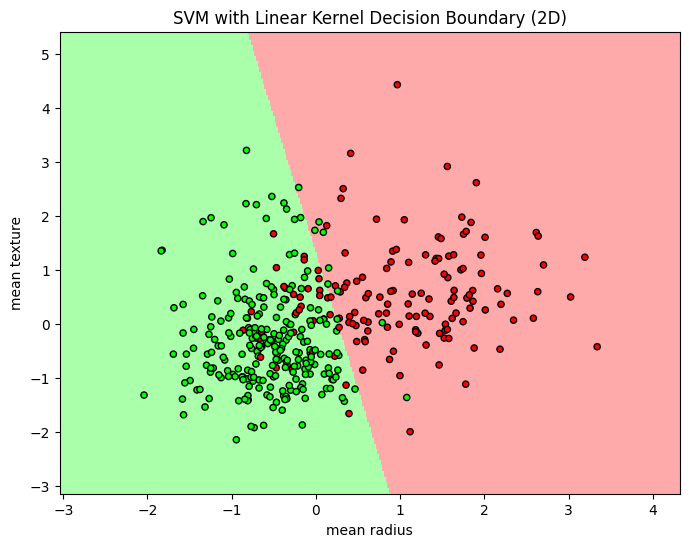

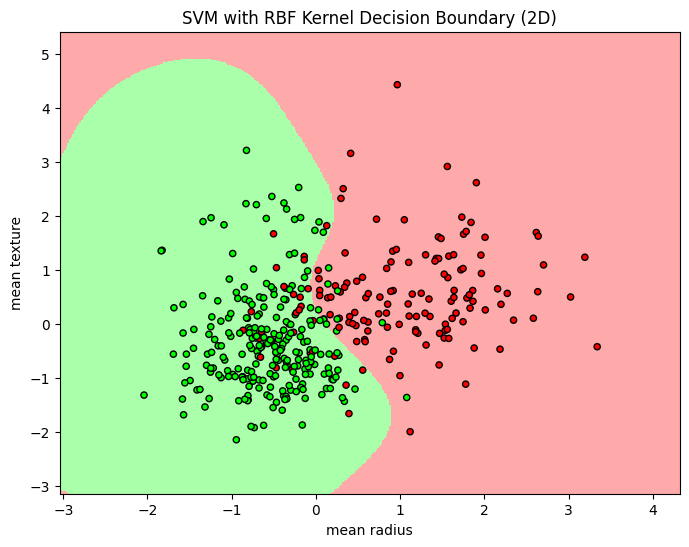

In [3]:
# 3. Visualize decision boundary using 2D data

def plot_decision_boundary(X, y, classifier, title):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFaa'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel(cancer.feature_names[0])
    plt.ylabel(cancer.feature_names[1])
    plt.show()

# Train 2D models for visualization
svm_linear_2d = SVC(kernel='linear', random_state=42)
svm_linear_2d.fit(X_train_2d_scaled, y_train_2d)

svm_rbf_2d = SVC(kernel='rbf', random_state=42)
svm_rbf_2d.fit(X_train_2d_scaled, y_train_2d)

plot_decision_boundary(X_train_2d_scaled, y_train_2d, svm_linear_2d, 'SVM with Linear Kernel Decision Boundary (2D)')
plot_decision_boundary(X_train_2d_scaled, y_train_2d, svm_rbf_2d, 'SVM with RBF Kernel Decision Boundary (2D)')

In [4]:
# 4. Tune hyperparameters like C and gamma

# Hyperparameter tuning for Linear SVM
param_grid_linear = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_linear = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_linear.fit(X_train_scaled, y_train)

print("\n--- Hyperparameter Tuning for Linear SVM ---")
print(f"Best parameters for Linear SVM: {grid_search_linear.best_params_}")
print(f"Best cross-validation score for Linear SVM: {grid_search_linear.best_score_:.4f}")
print(f"Test accuracy with best Linear SVM: {grid_search_linear.best_estimator_.score(X_test_scaled, y_test):.4f}")

# Hyperparameter tuning for RBF SVM
param_grid_rbf = {'C': [0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1, 'scale']} # 'scale' uses 1 / (n_features * X.var())
grid_search_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid_rbf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rbf.fit(X_train_scaled, y_train)

print("\n--- Hyperparameter Tuning for RBF SVM ---")
print(f"Best parameters for RBF SVM: {grid_search_rbf.best_params_}")
print(f"Best cross-validation score for RBF SVM: {grid_search_rbf.best_score_:.4f}")
print(f"Test accuracy with best RBF SVM: {grid_search_rbf.best_estimator_.score(X_test_scaled, y_test):.4f}")


--- Hyperparameter Tuning for Linear SVM ---
Best parameters for Linear SVM: {'C': 0.01}
Best cross-validation score for Linear SVM: 0.9799
Test accuracy with best Linear SVM: 0.9591

--- Hyperparameter Tuning for RBF SVM ---
Best parameters for RBF SVM: {'C': 10, 'gamma': 0.001}
Best cross-validation score for RBF SVM: 0.9799
Test accuracy with best RBF SVM: 0.9708


In [5]:
# 5. Use cross-validation to evaluate performance

# Evaluate the best Linear SVM model using cross-validation
best_svm_linear = grid_search_linear.best_estimator_
cv_scores_linear = cross_val_score(best_svm_linear, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("\n--- Cross-Validation Results for Best Linear SVM ---")
print(f"Cross-validation scores: {cv_scores_linear}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_linear):.4f}")
print(f"Standard deviation of cross-validation accuracy: {np.std(cv_scores_linear):.4f}")

# Evaluate the best RBF SVM model using cross-validation
best_svm_rbf = grid_search_rbf.best_estimator_
cv_scores_rbf = cross_val_score(best_svm_rbf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("\n--- Cross-Validation Results for Best RBF SVM ---")
print(f"Cross-validation scores: {cv_scores_rbf}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_rbf):.4f}")
print(f"Standard deviation of cross-validation accuracy: {np.std(cv_scores_rbf):.4f}")


--- Cross-Validation Results for Best Linear SVM ---
Cross-validation scores: [0.9875     0.975      0.975      0.97468354 0.98734177]
Mean cross-validation accuracy: 0.9799
Standard deviation of cross-validation accuracy: 0.0061

--- Cross-Validation Results for Best RBF SVM ---
Cross-validation scores: [0.9875     0.975      0.975      0.97468354 0.98734177]
Mean cross-validation accuracy: 0.9799
Standard deviation of cross-validation accuracy: 0.0061


These obtained results indicate that both linear and RBF kernels when optimally tuned, are highly effective and equally robust for classifying the Breast Cancer dataset.

This suggests the data is well-behaved for linear separation. When choosing between them, simplicity and potentially computational efficiency might lead you to favor the Linear SVM, as it delivers equivalent performance without the added complexity of a non-linear kernel for this particular problem.